# MLhandlers Tutorial

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api"s.<br>
More information about XGBoost - [here](https://en.wikipedia.org/wiki/XGBoost)

Multiple model types that can be estimated using the XGBoost Scikit-Learn API. <br>
Input can either be a predefined json model configuration or one
of the five xgboost model types. <br>
In either case one can pass in a params dict to modify defaults values.<br>
Based on `mlutils.models.gen_sklearn_model`, see the function
`sklearn_classifier` in the function-marketplace repository. <br>
> **param model_type:**
  one of "classifier", "regressor",
  "ranker", "rf_classifier", or
  "rf_regressor"<br>
> **param xgb_params:** class init parameters

## Steps
1. [Data Exploration](#Data-Exploration)
2. [Importing the function](#Importing-the-function)
3. [Setup XGBoost parameters](#Setup-XGBoost-parameters)
4. [Running the function locally](#Running-the-function-locally)
5. [Getting the model](#Getting-the-model)
6. [Some plotting](#Some-plotting)
7. [Running the function remotely](#Running-the-function-remotely)

In [4]:
import mlrun
mlrun.set_environment(project='ml-handlers')

> 2022-01-31 12:49:28,675 [info] loaded project ml-handlers from MLRun DB


('ml-handlers', 'v3io:///projects/{{run.project}}/artifacts')

### **Fetching a Dataset**

To generate the dataset we used the "gen_class_data" function from the hub, 
which wraps scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn-datasets-make-classification).<br> 
See the link for a description of all parameters.

In [5]:
import pandas as pd
dataset_url = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv'

In [6]:
df = pd.read_csv(dataset_url)
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,labels
0,-0.265115,-1.932260,0.303992,-1.863833,-1.045635,1
1,-3.135479,-2.835548,1.338381,-1.385303,-2.276456,0
2,-1.519005,-1.807549,0.697304,-1.118860,1.104900,0
3,-0.632087,-0.345659,0.244329,-0.046066,0.447280,0
4,-1.405883,-1.746045,0.653617,-1.110985,-1.675466,0


### **Importing the MLhandlers functions from the Marketplace**

In [8]:
# If GPU is available - set to True
# GPU = False

# fn = mlrun.import_function("hub://xgb_trainer")
# fn.image = "mlrun/ml-models" if not GPU else "mlrun/ml-models-gpu"
# fn.apply(mlrun.auto_mount())

In [9]:
import mlrun
from mlrun import code_to_function, import_function

fn = mlrun.import_function("./MLhandlers.yaml")

### **Training a model**

#### Define task parameters¶

In [22]:
train_params = {
                "label_column": "labels",
                "model_class": "sklearn.linear_model.LogisticRegression",
                "artifacts": {"confusion_matrix": {}},
               }

#### Running the Training job with the "train" handler

In [23]:
import mlrun
from mlrun import code_to_function, import_function

train_run = fn.run(params = train_params,    
                   inputs={"dataset": dataset_url},
                   handler='train',
                   local=True)

> 2022-01-31 13:22:56,770 [info] starting run predict-train uid=b204c9b9717d451094d0a83026a89649 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ml-handlers,...26a89649,0,Jan 31 13:22:56,completed,predict-train,v3io_user=alexzkind=owner=alexzhost=alexz-jupyter-66555599cb-mlrnq,dataset,label_column=labelsmodel_class=sklearn.linear_model.LogisticRegressionartifacts={'confusion_matrix': {}},accuracy_score=0.896f1_score=0.8924508790072389precision_score=0.9093782929399368recall_score=0.8761421319796955,confusion_matrixLogisticRegression


> 2022-01-31 13:22:58,124 [info] run executed, status=completed


#### How about other frameworks?

In [34]:
task_params = {"label_column": "labels",
              "model_class": "xgboost.XGBRegressor"}

In [35]:
xgb_run = fn.run(params = task_params,    
                   inputs={"dataset": dataset_url},
                   handler='train',
                   local=True)

> 2022-01-30 14:34:52,092 [info] starting run predict-train uid=2edf6d3783754584bc49b88e80732d84 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ml-handlers,...80732d84,0,Jan 30 14:34:52,completed,predict-train,v3io_user=alexzkind=owner=alexzhost=alexz-jupyter-66555599cb-mlrnq,dataset,label_column=labelsmodel_class=xgboost.XGBRegressor,r2_score=0.8663806826349162mean_absolute_error=0.06956097900867463mean_squared_error=0.18272153180878664,test_settrained_model


> 2022-01-30 14:34:55,332 [info] run executed, status=completed


### **Evaluating a model**

#### Define task parameters¶

In [36]:
eval_params = {"label_column": "labels",
              "model_path": train_run.outputs["trained_model"]}

#### Running our Evaluation job with the "evaluate" handler

In [37]:
eval_run = fn.run(
                params = eval_params,
                inputs = {'dataset': dataset_url},
                handler='evaluate',
                local=True
                )

> 2022-01-30 14:34:55,351 [info] starting run predict-evaluate uid=5000ec47729742ec9a262809a828724c DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ml-handlers,...a828724c,0,Jan 30 14:34:55,completed,predict-evaluate,v3io_user=alexzkind=owner=alexzhost=alexz-jupyter-66555599cb-mlrnq,dataset,label_column=labelsmodel_path=store://artifacts/ml-handlers/trained_model:04ee91634e164702abb89f5627f226ed,r2_score=0.9550375284103801mean_absolute_error=0.03696698710024357mean_squared_error=0.10602164458931557,test_set


> 2022-01-30 14:34:56,477 [info] run executed, status=completed


### **Predicting on new data**

#### Fetching a new dataset

In [38]:
new_dataset_url = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv'

#### Define task parameters¶

In [39]:
predict_params = {"label_column": "labels",
              "model_path": train_run.outputs["trained_model"]}

#### Running our Predict job with the "predict" handler

In [40]:
predict_run = fn.run(
                params = predict_params,
                inputs = {'dataset': new_dataset_url},
                handler='predict',
                local=True
                )

> 2022-01-30 14:35:00,373 [info] starting run predict-predict uid=96dc3e908b874e28a2348f9ad6c6111f DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ml-handlers,...d6c6111f,0,Jan 30 14:35:00,completed,predict-predict,v3io_user=alexzkind=owner=alexzhost=alexz-jupyter-66555599cb-mlrnq,dataset,label_column=labelsmodel_path=store://artifacts/ml-handlers/trained_model:04ee91634e164702abb89f5627f226ed,,


> 2022-01-30 14:35:01,027 [info] run executed, status=completed


### **Getting the model**

In [ ]:
from mlrun.artifacts import get_model
import pickle

model_file, model_obj, _ = get_model(train_run.artifact('model'))
model = pickle.load(open(model_file,'rb'))

In [ ]:
print(f"model score : {model.score(train_run.artifact('test_set').as_df().drop(['labels'],axis=1),train_run.artifact('test_set').as_df()['labels'])}")

### **Some plotting**

#### Display the probability calibration

In [43]:
train_run.artifact('probability_calibration').show()

AttributeError: 'NoneType' object has no attribute 'show'


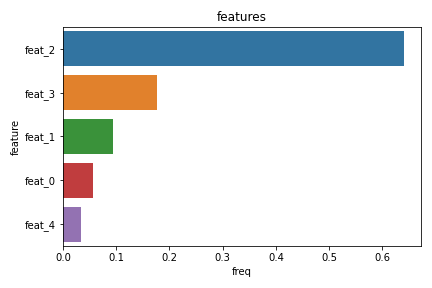

In [10]:
train_run.artifact('feature-importances').show()

### **Running the function remotely**

In [11]:
fn.spec.build.commands=['pip install xgboost==1.3.1']
fn.deploy(with_mlrun=False)

> 2021-10-13 10:10:24,882 [info] Started building image: .mlrun/func-function-marketplace-xgb-trainer:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0001] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0002] Executing 0 build triggers                   
INFO[0002] Unpacking rootfs as cmd RUN pip install xgboost==1.3.1 requires it. 
INFO[0024] RUN pip install xgboost==1.3.1               
INFO[0024] Taking snapshot of full filesystem...        
INFO[0035] cmd: /bin/sh                                 
INFO[0035] args: [-c pip install xgboost==1.3.1]        
INFO[0035] Running: [/bin/sh -c pip install xgboost==1.3.1] 
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
INFO[0042] Taking snapshot of full filesystem...        


True

In [12]:
fn.run(inputs={"dataset"  : 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv'},
       params=task_params)

> 2021-10-13 10:11:39,577 [info] starting run xgb-trainer-train_model uid=7332ff5d727948c89221d4645b84d028 DB=http://mlrun-api:8080
> 2021-10-13 10:11:39,764 [info] Job is running in the background, pod: xgb-trainer-train-model-4scfq
> 2021-10-13 10:11:55,207 [info] run executed, status=completed
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...5b84d028,0,Oct 13 10:11:51,completed,xgb-trainer-train_model,v3io_user=danikind=jobowner=danihost=xgb-trainer-train-model-4scfq,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9552test-error=0.0448rocauc=0.9799618829687036brier_score=0.038984999293145965f1-score=0.954983922829582precision_score=0.965679190751445recall_score=0.9445229681978798,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


> 2021-10-13 10:11:58,969 [info] run executed, status=completed


[Back to the top](#XGBoost-trainer)